# Surface Tracking - Images

In [1]:
import typing as T

In [2]:
from surface_tracker import (
    CameraModel,
    CornerId,
    Marker, MarkerId,
    Surface, SurfaceId,
    SurfaceLocation,
    SurfaceTracker,
    SurfaceVisualAnchors,
)

### API Overview

```python3
from surface_tracker import SurfaceTracker


# Instace implementing the `surface_tracker.CameraModel` interface.
#
# This version of the library does not provide a concrete implementation of this interface,
# so library clients must implement a concrete subclass of `surface_tracker.CameraModel`.
camera_model = ...


# List of the detected instances of `surface_tracker.Marker` class.
detected_markers_in_frame_n = ...


# Main entry point of the library API;
# used to define and locate surfaces based on
# a list of markers and a camera model
surface_tracker = SurfaceTracker()


my_surface = surface_tracker.define_surface(
    name="My Surface",
    markers=detected_markers_in_frame_n,
    camera_model=camera_model,
)


detected_markers_in_frame_k = ...


surface_location_within_frame_k = surface_tracker.locate_surface(
    surface=my_surface,
    markers=detected_markers_in_frame_k,
    camera_model=camera_model,
)
```

## Implementing the interfaces

Bellow are basic implementations of the parts that are not provided by the library.

### Camera model

The current version of the `surface_tracker` library does **not** provide a concrete implementation of the `CameraModel` interface.

The client of the library **must** implement the interface to be able to use the library.

In [3]:
import numpy as np
import cv2


# Source: pupil/pupil_src/shared_modules/camera_model.py
class RadialDistorsionCamera(CameraModel):
    """ Camera model assuming a lense with radial distortion (this is the defaut model in opencv).
        Provides functionality to make use of a pinhole camera calibration that is also compensating for lense distortion
    """

    def __init__(self, name, resolution, K, D):
        self.name = name
        self.resolution = resolution
        self.K = np.array(K)
        self.D = np.array(D)

    # CameraModel Interface

    def undistort_points_on_image_plane(self, points):
        points = self.__unprojectPoints(points, use_distortion=True)
        points = self.__projectPoints(points, use_distortion=False)
        return points

    def distort_points_on_image_plane(self, points):
        points = self.__unprojectPoints(points, use_distortion=False)
        points = self.__projectPoints(points, use_distortion=True)
        return points

    # Private

    def __projectPoints(self, object_points, rvec=None, tvec=None, use_distortion=True):
        """
        Projects a set of points onto the camera plane as defined by the camera model.
        :param object_points: Set of 3D world points
        :param rvec: Set of vectors describing the rotation of the camera when recording the corresponding object point
        :param tvec: Set of vectors describing the translation of the camera when recording the corresponding object point
        :return: Projected 2D points
        """
        input_dim = object_points.ndim

        object_points = object_points.reshape((1, -1, 3))

        if rvec is None:
            rvec = np.zeros(3).reshape(1, 1, 3)
        else:
            rvec = np.array(rvec).reshape(1, 1, 3)

        if tvec is None:
            tvec = np.zeros(3).reshape(1, 1, 3)
        else:
            tvec = np.array(tvec).reshape(1, 1, 3)

        if use_distortion:
            _D = self.D
        else:
            _D = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0]])

        image_points, jacobian = cv2.projectPoints(
            object_points, rvec, tvec, self.K, _D
        )

        if input_dim == 2:
            image_points.shape = (-1, 2)
        elif input_dim == 3:
            image_points.shape = (-1, 1, 2)
        return image_points

    def __unprojectPoints(self, pts_2d, use_distortion=True, normalize=False):
        """
        Undistorts points according to the camera model.
        :param pts_2d, shape: Nx2
        :return: Array of unprojected 3d points, shape: Nx3
        """
        pts_2d = np.array(pts_2d, dtype=np.float32)

        # Delete any posibly wrong 3rd dimension
        if pts_2d.ndim == 1 or pts_2d.ndim == 3:
            pts_2d = pts_2d.reshape((-1, 2))

        # Add third dimension the way cv2 wants it
        if pts_2d.ndim == 2:
            pts_2d = pts_2d.reshape((-1, 1, 2))

        if use_distortion:
            _D = self.D
        else:
            _D = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0]])

        pts_2d_undist = cv2.undistortPoints(pts_2d, self.K, _D)

        pts_3d = cv2.convertPointsToHomogeneous(pts_2d_undist)
        pts_3d.shape = -1, 3

        if normalize:
            pts_3d /= np.linalg.norm(pts_3d, axis=1)[:, np.newaxis]

        return pts_3d


In [4]:
camera_model = RadialDistorsionCamera(
    name="Radial Distorsion Camera",
    resolution=(1280, 720),
    K=[
        [829.3510515270362, 0.0, 659.9293047259697],
        [0.0, 799.5709408845464, 373.0776462356668],
        [0.0, 0.0, 1.0],
    ],
    D=[
        [
            -0.43738542863224966,
            0.190570781428104,
            -0.00125233833830639,
            0.0018723428760170056,
            -0.039219091259637684,
        ]
    ],
)
camera_model

### Marker detector

This example is using surfaces defined by `apriltag` markers.

Bellow is a wrapper around the `apriltag` detector provided by the `pupil_apriltags` library. The most importat part that the wrapper does is construct `surface_tracker.Marker` instances from the `apriltag` detections.

In [5]:
import pupil_apriltags


class ApriltagDetector:

    def __init__(
        self,
        *families: T.Set[str],
    ):
        families = " ".join(families)
        self._detector = pupil_apriltags.Detector(families=families)

    def detect_from_image(self, image) -> T.List[Marker]:
        gray = rgb_to_gray(image)
        return self.detect_from_gray(gray)

    def detect_from_gray(self, gray) -> T.List[Marker]:
        
        # Detect apriltag markers from the gray image
        markers = self._detector.detect(gray)

        # Ensure detected markers are unique
        # TODO: Between deplicate markers, pick the one with higher confidence
        uid_fn = self.__apriltag_marker_uid
        markers = dict((uid_fn(m), m) for m in markers).values()

        # Convert apriltag markers into surface tracker markers
        marker_fn = self.__apriltag_marker_to_surface_marker
        markers = [marker_fn(m) for m in markers]

        return markers

    @staticmethod
    def __apriltag_marker_uid(apriltag_marker: pupil_apriltags.Detection) -> str:
        # Construct the UID by concatinating the tag family and the tag id
        return f"{apriltag_marker.tag_family}:{apriltag_marker.tag_id}"

    @staticmethod
    def __apriltag_marker_to_surface_marker(apriltag_marker: pupil_apriltags.Detection) -> Marker:

        # Construct the surface tracker marker UID
        uid = ApriltagDetector.__apriltag_marker_uid(apriltag_marker)
        uid = MarkerId(uid)

        # Extract vertices in the correct format form apriltag marker
        vertices = [[point] for point in apriltag_marker.corners]

        # TODO: Verify this is correct...
        starting_with = CornerId.TOP_LEFT
        clockwise = True

        return Marker.from_vertices(
            uid=uid,
            vertices=vertices,
            starting_with=starting_with,
            clockwise=clockwise
        )


Finally, here are some helper functions that load sample images, and visualize images enriched by the data supplied by the `surface_tracker` library.

In [6]:
import matplotlib.pyplot as plt
from PIL import Image


### Loading images


def load_image(path: str) -> np.ndarray:
    image = Image.open(path)
    image = np.asarray(image)
    return image


def load_sample_image(name: str, frame_index: int) -> np.ndarray:
    i = str(frame_index).rjust(3, "0")
    path = f"./sample_data/{name}/frame_{i}.jpg"
    return load_image(path)


### Converting images


def rgb_to_gray(image: np.ndarray) -> np.ndarray:
    image = Image.fromarray(image)
    image = image.convert("L")
    image = np.asarray(image)
    return image


### Overlaying information on images


def overlay_surface_visual_anchors(image: np.ndarray, anchors: SurfaceVisualAnchors) -> np.ndarray:
    image = overlay_polyline(image, anchors.top_polyline, color=(0, 0, 255))
    image = overlay_polyline(image, anchors.perimeter_polyline, color=(255, 0, 0))
    # TODO: Overlay menu edit buttons
    return image


def overlay_markers(image: np.ndarray, markers: T.List[Marker], color=(0, 255, 0), alpha=0.7) -> np.ndarray:
    vertices = np.asarray([m.vertices() for m in markers], dtype=np.int32)
#     vertices = np_markers.reshape((-1, 4, 2))
    overlay = np.zeros_like(image)
    overlay = cv2.fillPoly(overlay, vertices, color)
    image = cv2.addWeighted(image, 1.0, overlay, alpha, 0.0)
    return image


def overlay_polyline(image: np.ndarray, points, color, is_closed=True, thickness=2) -> np.ndarray:
    points = np.array([points], dtype=np.int32)
    return cv2.polylines(image, points, isClosed=is_closed, color=color, thickness=thickness)


def overlay_polyfill(image: np.ndarray, points, color) -> np.ndarray:
    return image  # FIXME


def overlay_text(image: np.ndarray, point, text: str) -> np.ndarray:
    return image  # FIXME


### Showing images


def show_markers(image: np.ndarray, markers: T.List[Marker]):
    image = overlay_markers(image, markers)
    show_image(image)


def show_surface(image: np.ndarray, surface: Surface, surface_tracker: SurfaceTracker, camera_model: CameraModel):
    gray = rgb_to_gray(image)

    markers = self.marker_detector.detect_from_gray(gray)

    image = overlay_markers(image, markers)

    location = self.surface_tracker.locate_surface(
        surface=surface,
        markers=markers,
        camera_model=camera_model,
    )
    
    if location is not None:
        # TODO: Overlay surface name
        show_location(image, location, surface_tracker, camera_model)
    else:
        show_image(image)


def show_location(image: np.ndarray, location: SurfaceLocation, surface_tracker: SurfaceTracker, camera_model: CameraModel):
    visual_anchors = surface_tracker.locate_visual_anchors(
        location=location,
        camera_model=camera_model,
    )
    show_visual_anchors(image, visual_anchors)


def show_visual_anchors(image: np.ndarray, anchors: SurfaceVisualAnchors):
    image = overlay_surface_visual_anchors(image, anchors)
    show_image(image)


def show_image(image: np.ndarray, figure_size=30):
    ratio = image.shape[0] / image.shape[1]
    fig, ax = plt.subplots(figsize=(figure_size*ratio, figure_size))
    if len(image.shape) == 2:
        ax.imshow(image, interpolation=None, cmap='gray')
    else:
        ax.imshow(image, interpolation=None)
    plt.show()


## Putting it all together

First, the `1`st frame from the `apriltag_world` video is loaded. This will be used to define the surface.

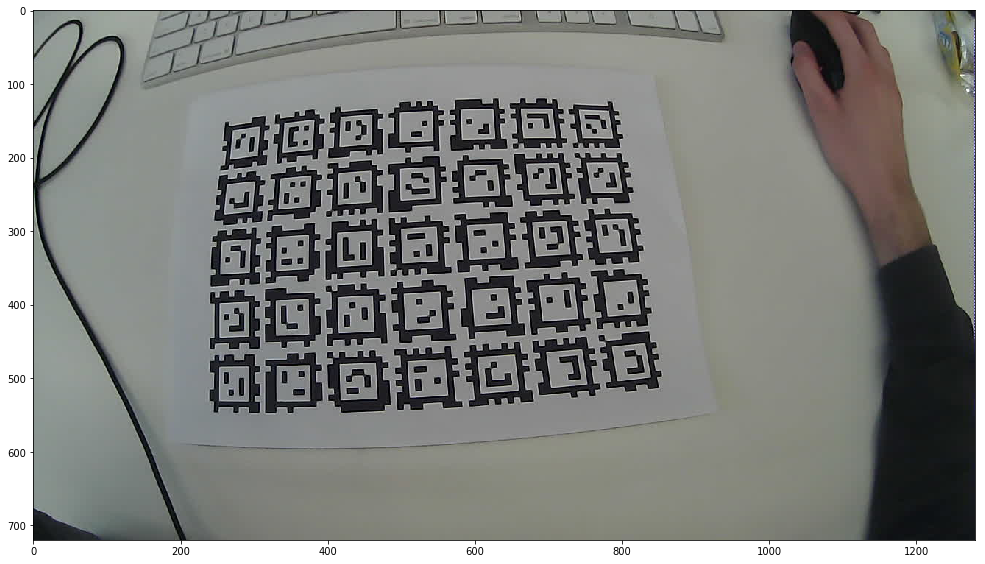

In [7]:
image_1 = load_sample_image("apriltag_world", frame_index=1)
show_image(image_1)

Next, the `apriltag` detector is run to find all the markers in the image. These markers will define the surface.

In [8]:
apriltag_detector = ApriltagDetector("tagCustom48h12")
apriltag_detector

Detected 35 markers.


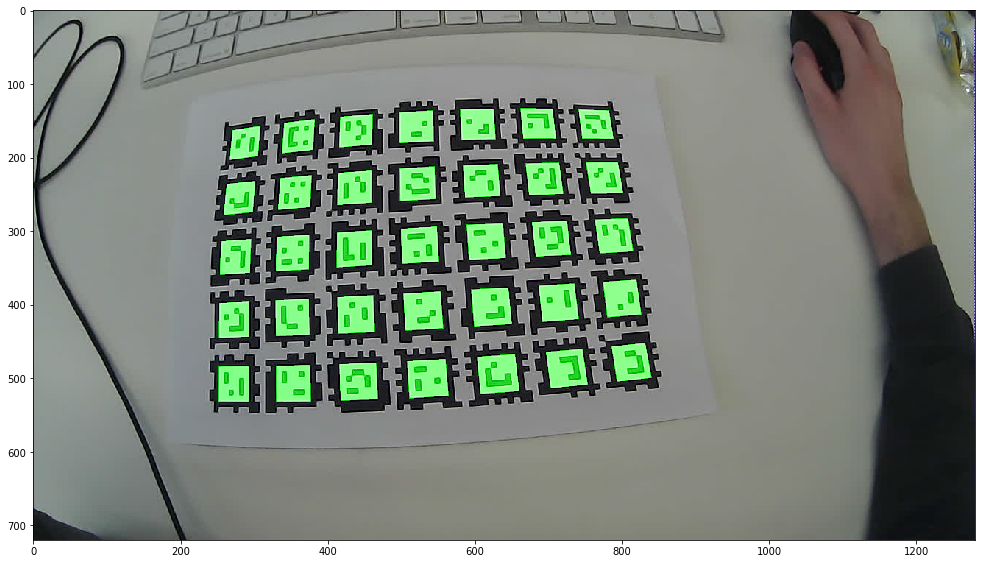

In [9]:
detected_markers_1 = apriltag_detector.detect_from_image(image_1)
print(f"Detected {len(detected_markers_1)} markers.")
show_markers(image_1, detected_markers_1)

Next, the `SurfaceTracker` instance is used to define a surface called `"My Surface"`. This definition will be used to locate the surface within any frame where a subset of the markers used in the definition are present.

In [10]:
surface_tracker = SurfaceTracker()
surface_tracker

In [11]:
my_surface = surface_tracker.define_surface(
    name="My Surface",
    markers=detected_markers_1,
    camera_model=camera_model,
)
my_surface

Bellow is an example of how to locate the surface. As a test that the definition is correct, the next cell visualizes the surface within the same frame that was used to define the surface.

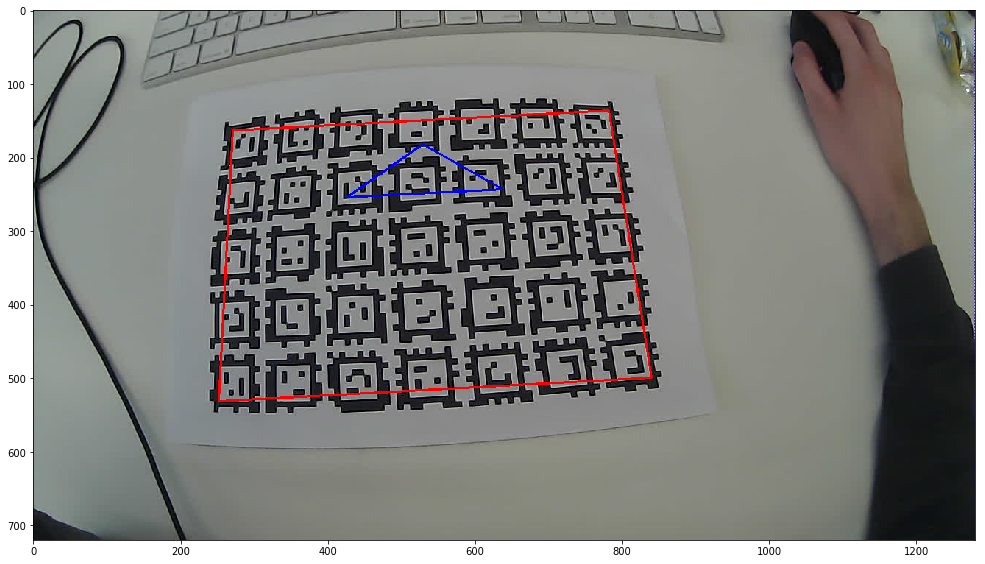

In [12]:
my_surface_location_within_frame_1 = surface_tracker.locate_surface(
    surface=my_surface,
    markers=detected_markers_1,
    camera_model=camera_model,
)
show_location(image_1, my_surface_location_within_frame_1, surface_tracker, camera_model)

Finally, to test that the definition works within any frame, the code bellow loads a different frame, detects the markers preset in the image, locates the surface within the frame, and visualizes the result.

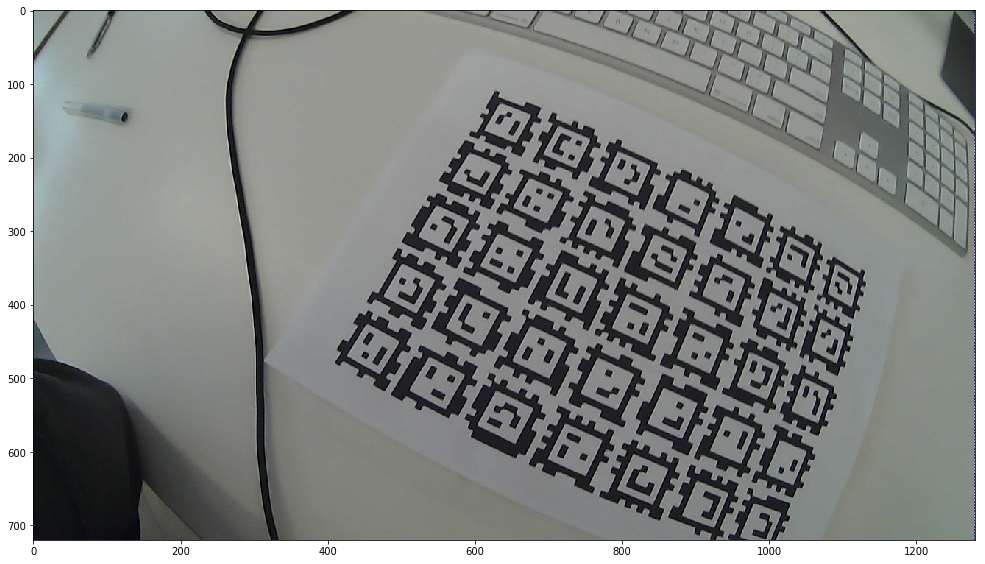

In [13]:
image_4 = load_sample_image("apriltag_world", frame_index=4)
show_image(image_4)

Detected 34 markers.


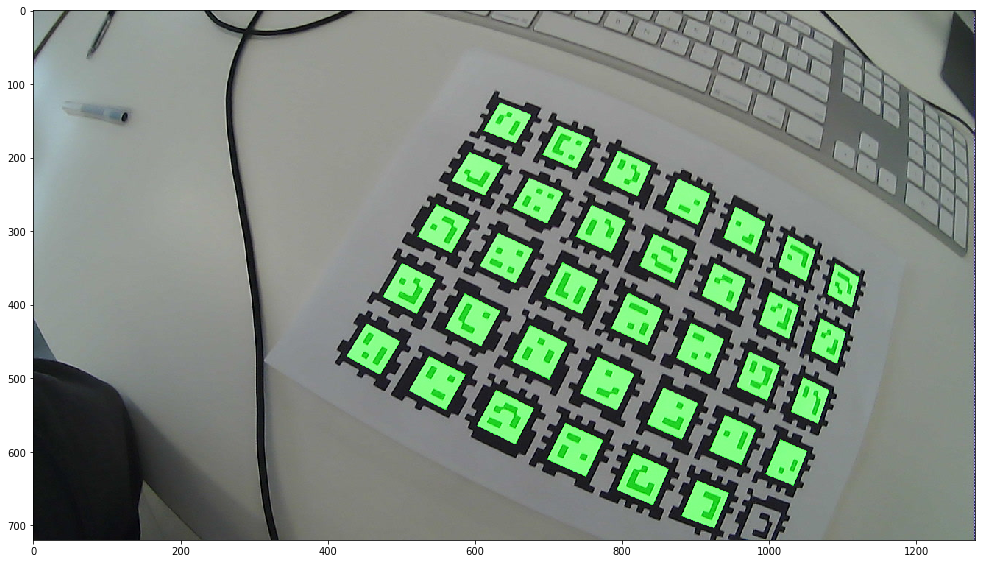

In [14]:
detected_markers_4 = apriltag_detector.detect_from_image(image_4)
print(f"Detected {len(detected_markers_4)} markers.")
show_markers(image_4, detected_markers_4)

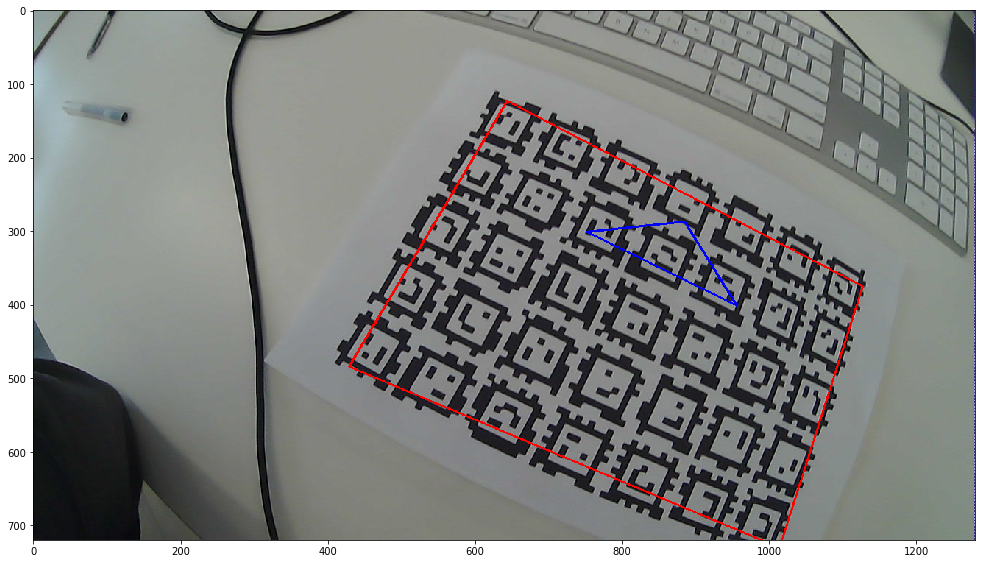

In [15]:
my_surface_location_within_frame_4 = surface_tracker.locate_surface(
    surface=my_surface,
    markers=detected_markers_4,
    camera_model=camera_model,
)
show_location(image_4, my_surface_location_within_frame_4, surface_tracker, camera_model)